# Dataset Exploration

We explore our dataset, driven by the following questions:

1. **How many comments does user X have?**
2. **What are typical times for comments? Given a user X, what time(s) are they commenting?**
3. **What channel(s) is user X commenting on?**
4. **How close to a video's upload time is user X commenting?**
5. **Are there perceived or underlying patterns in user X's comments?**

## 0. Setup

We connect to the Postgres container locally

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
from pathlib import Path

project_root = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())
sys.path.insert(0, str(project_root)) # Make root directory the cwd

from dotenv import load_dotenv
load_dotenv()

# Override Postgres env variables for local runtime
os.environ["POSTGRES_PORT"] = os.getenv("POSTGRES_PORT_LOCAL", 5555)
os.environ["POSTGRES_HOST"] = "localhost"

from src.data.psql import Psql

psql_client = Psql()

## 1. Querying comment counts based on user

In [9]:
psql_client.rollback()

In [4]:
query = """
SELECT u.username, u.userId, COUNT(c.commentId) AS commentCount
FROM Yt.Users AS u
JOIN Yt.Comments as c
    ON u.userId = c.commenterId
GROUP BY u.userId, u.username
HAVING COUNT(c.commentId) > 3
ORDER BY commentCount DESC;
"""

result = psql_client.query(query)
print("Top 10 commenters:\n")
for i in range(10):
    print(result[i])

Top 10 commenters:

('@michaelmurphy6195', 'UC0TrFwDaV06zckO6v5f6mIQ', 143)
('@josephsonora3787', 'UC3XEpDanrCsH_k3yxkq_hZg', 127)
('@Michael-z5t3h', 'UCNiwLeKNdIisbd74yA5MitA', 120)
('@Detroit100', 'UCEV07swyCZst6xyPzZ2JPbA', 119)
('@TommyDukeMorrison', 'UCNO03OcZ1M22hkUHoeuC-dQ', 118)
('@starrymessenger-o4j', 'UCV9ZPHxCFnrf1BfbGWCLncQ', 111)
('@MichaelS-bz4pk', 'UCsuOuvzHQ6AzYpyJGORdymg', 110)
('@DaveSchultzXXL', 'UCoOJg6dZZvzCEeFUj7ECQCg', 107)
('@Chocojay165', 'UCTrxIWNCl0sVZmE3JKJem8g', 105)
('@t.r.campbell6585', 'UCdn0s4rhv0A6JYgn-M1_Kxg', 104)


## 2. Finding times of comments of a particular user

Let's observe the times of **@Michael-z5t3h**'s comments

In [64]:
def get_user_comment_distribution(user_id: str):
    query = """
    SELECT c.publishDate AS commentHour
    FROM Yt.Comments AS c
    WHERE c.commenterId = %s;
    """
    comment_times = psql_client.query(query, (user_id,))
    comment_times = [time[0] for time in comment_times]
    
    df = pd.DataFrame({'datetime': comment_times})
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

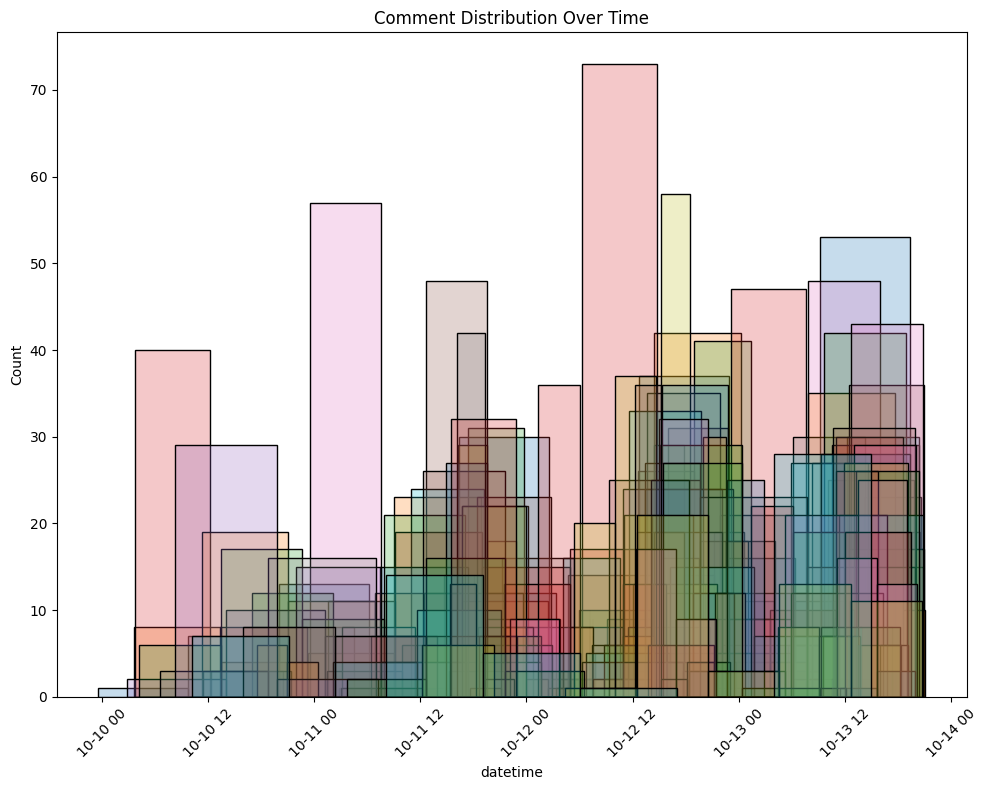

In [82]:
plt.figure(figsize=(10,8))

for i in range(50):
    user_id = result[i][1]
    df = get_user_comment_distribution(user_id)
    
    sns.histplot(data=df, x='datetime', alpha=0.25, label=user_id)

plt.xticks(rotation=45)
plt.title('Comment Distribution Over Time')
plt.tight_layout()
plt.show()

Right now, this is purely raw datetimes. It might be more insightful to get the distributions of the hour of day these users are commenting

In [74]:
def get_user_hour_distribution(user_id):
    df = get_user_comment_distribution(user_id)
    df["hour"] = df["datetime"].dt.hour
    
    return pd.DataFrame(df["hour"])

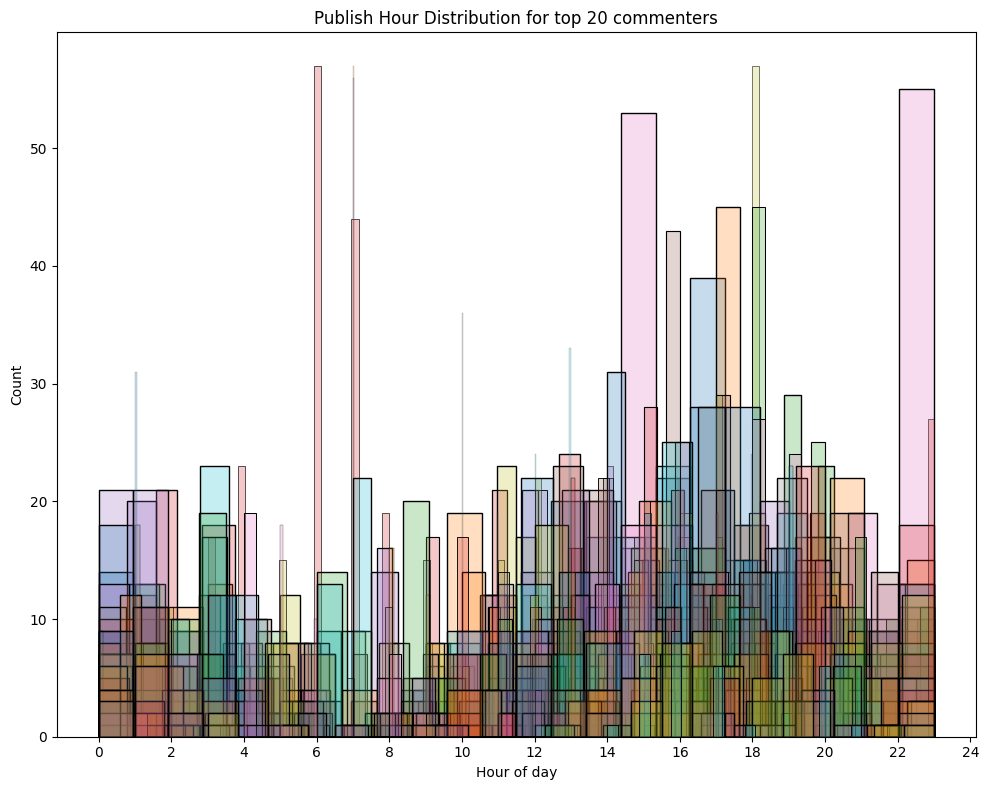

In [78]:
plt.figure(figsize=(10, 8))

for i in range(200):
    user_id = result[i][1]
    df = get_user_hour_distribution(user_id)
    sns.histplot(data=df, x="hour", bins=24, alpha=0.25, label=user_id)
    
plt.xlabel("Hour of day")
plt.xticks(np.arange(0, 25, 2))
plt.title("Publish Hour Distribution for top 20 commenters")
plt.tight_layout()
plt.show()
    

We can observe a general dip in comment frequency, which likely represents usual sleeping hours. However, there are some visible outliers, shown by the thin bars around hour 6

## 3. Comment Speed

We would also want to observe how quickly users are commenting upon video publishing.

We filter out uploads within the last 24 hours to allow for a more

In [91]:
psql_client.rollback()

In [ ]:
query = """
SELECT c.commenterId, c.publishDate, v.publishDate, 
    EXTRACT(EPOCH FROM (c.publishDate - v.publishDate)) / 60 AS commentLatencyMinutes
FROM YT.Comments AS c
JOIN Yt.Videos AS v
    ON c.videoId = v.videoId;
"""

comment_video = psql_client.query(query)


In [101]:
comment_video[0]

('UCMSobC7lyIxCukAx-4viKTw',
 datetime.datetime(2025, 10, 12, 23, 45, 14),
 datetime.datetime(2025, 10, 12, 23, 34, 2),
 Decimal('11.2000000000000000'))

In [88]:
comment_video[0]

('Ugwi-DoZ5u2M_K0Z5nR4AaABAg',
 'UCMSobC7lyIxCukAx-4viKTw',
 '7NFGI01k7E4',
 True,
 None,
 datetime.datetime(2025, 10, 12, 23, 45, 14),
 datetime.datetime(2025, 10, 12, 23, 45, 14),
 0,
 'He is pond scum!!!!',
 'v2:[2025-10-12 23:47:26]',
 datetime.datetime(2025, 10, 12, 23, 47, 26, 278834),
 '7NFGI01k7E4',
 'Maddow: Trump wants to terrify with indictments, but it will unify opposition',
 datetime.datetime(2025, 10, 12, 23, 34, 2),
 '',
 'v2:[2025-10-12 23:47:26]',
 datetime.datetime(2025, 10, 12, 23, 47, 26, 275987))